   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.8 MB/s eta 0:00:00
Mounted at /content/drive

📁 Dataset Validation:
✅ /content/drive/MyDrive/dataset/train/Degradable - 361 images
✅ /content/drive/MyDrive/dataset/train/Non degradable - 363 images
✅ /content/drive/MyDriv

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.0MB/s]


📚 Epoch 1/3 - Loss: 0.2246, Training Accuracy: 90.33%
📚 Epoch 2/3 - Loss: 0.0632, Training Accuracy: 97.65%
📚 Epoch 3/3 - Loss: 0.0199, Training Accuracy: 99.59%
✅ Validation Accuracy: 96.94%

🚀 Training with lr=0.0001, optimizer=Adam, batch_size=32
📚 Epoch 1/3 - Loss: 0.2361, Training Accuracy: 90.75%
📚 Epoch 2/3 - Loss: 0.0383, Training Accuracy: 99.03%
📚 Epoch 3/3 - Loss: 0.0097, Training Accuracy: 99.86%
✅ Validation Accuracy: 97.96%

🚀 Training with lr=0.0001, optimizer=SGD, batch_size=16
📚 Epoch 1/3 - Loss: 0.6541, Training Accuracy: 63.95%
📚 Epoch 2/3 - Loss: 0.4125, Training Accuracy: 84.94%
📚 Epoch 3/3 - Loss: 0.3223, Training Accuracy: 89.09%
✅ Validation Accuracy: 86.73%

🚀 Training with lr=0.0001, optimizer=SGD, batch_size=32
📚 Epoch 1/3 - Loss: 0.6796, Training Accuracy: 58.01%
📚 Epoch 2/3 - Loss: 0.5118, Training Accuracy: 77.62%
📚 Epoch 3/3 - Loss: 0.4074, Training Accuracy: 85.64%
✅ Validation Accuracy: 85.71%

🚀 Training with lr=0.001, optimizer=Adam, batch_size=16
📚 E

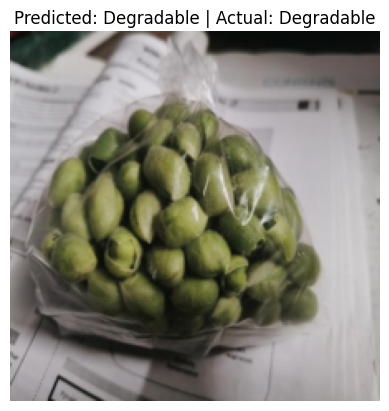

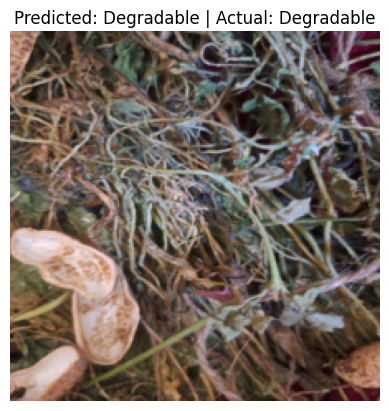

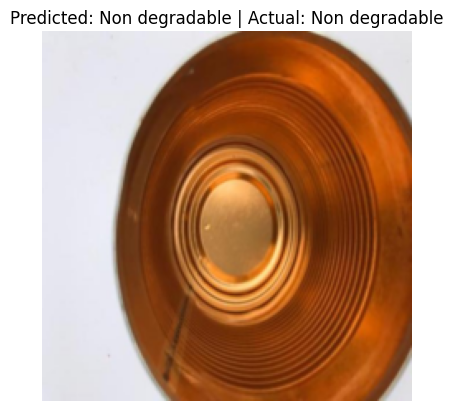

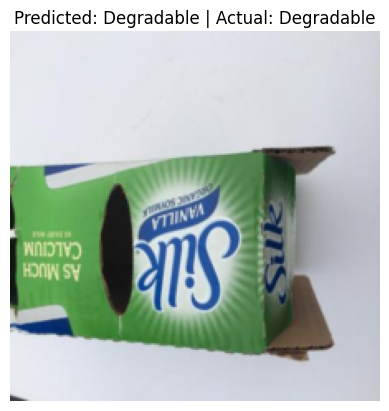

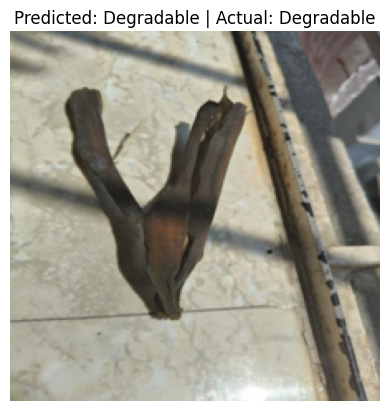

In [1]:
!pip install -q ptflops

# ✅ 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ✅ 2. Imports
import os, random, time
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from ptflops import get_model_complexity_info
import numpy as np

# ✅ 3. Dataset path
data_dir = "/content/drive/MyDrive/dataset"

# ✅ 4. Dataset validation
print("\n📁 Dataset Validation:")
for split in ["train", "valid", "test"]:
    for cls in ["Degradable", "Non degradable"]:
        path = os.path.join(data_dir, split, cls)
        if not os.path.exists(path):
            print(f"❌ MISSING: {path}")
        else:
            files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            print(f"✅ {path} - {len(files)} images")
            if len(files) == 0:
                print(f"⚠ No valid image files found in {path}")
print("\n")

# ✅ 5. Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ 6. Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)
class_names = train_dataset.classes

# ✅ 7. Hyperparameter grid
param_grid = {
    'lr': [1e-4, 1e-3],
    'optimizer': ['Adam', 'SGD'],
    'batch_size': [16, 32]
}

best_model = None
best_acc = 0
best_config = None

# ✅ 8. Grid Search
start_time = time.time()  # ⏱ Start timing
for lr in param_grid['lr']:
    for opt_name in param_grid['optimizer']:
        for batch_size in param_grid['batch_size']:
            print(f"\n🚀 Training with lr={lr}, optimizer={opt_name}, batch_size={batch_size}")

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 2)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = model.to(device)

            criterion = nn.CrossEntropyLoss()
            if opt_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            else:
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            num_epochs = 3
            for epoch in range(num_epochs):
                model.train()
                running_correct = 0
                running_total = 0
                running_loss = 0.0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    _, predicted = outputs.max(1)
                    running_total += labels.size(0)
                    running_correct += predicted.eq(labels).sum().item()
                    running_loss += loss.item() * inputs.size(0)

                train_acc = 100 * running_correct / running_total
                avg_loss = running_loss / running_total
                print(f"📚 Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

            # Validation
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

            acc = 100 * correct / total
            print(f"✅ Validation Accuracy: {acc:.2f}%")

            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_config = {'lr': lr, 'optimizer': opt_name, 'batch_size': batch_size}

end_time = time.time()  # ⏱ End timing
total_time_sec = end_time - start_time
total_time_min = total_time_sec / 60

print(f"\n⏱ Total Training & Tuning Time: {total_time_sec:.2f} sec ({total_time_min:.2f} min)")
print(f"🏆 Best Config: {best_config}, Accuracy: {best_acc:.2f}%")

# ✅ 9. Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'], shuffle=False)
best_model.eval()
all_preds, all_labels, all_probs = [], [], []
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        _, predicted = probs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_acc = 100 * correct / total
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
roc_auc = roc_auc_score(all_labels, [p[1] for p in all_probs])  # ✅ binary-safe

# ✅ 10. Print final metrics
print("\n📊 Final Test Performance:")
print(f"✔ Test Accuracy: {test_acc:.2f}%")
print(f"✔ Precision: {precision:.2f}")
print(f"✔ Recall: {recall:.2f}")
print(f"✔ F1 Score: {f1:.2f}")
print(f"✔ ROC-AUC: {roc_auc:.2f}")
print(f"⏱ Total Time: {total_time_sec:.2f} sec ({total_time_min:.2f} min)")

# ✅ 11. Confusion Matrix
print("\n📌 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# ✅ 12. Model Complexity
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(best_model, (3, 224, 224), as_strings=True, print_per_layer_stat=False)
print(f"\n🧠 Model Parameters: {params}")
print(f"⚙ FLOPs: {macs}")

# ✅ 13. Sample Predictions
def predict_from_dataset(dataset, model, class_names, num_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    for idx in indices:
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
        true_class = class_names[label]
        plt.imshow(F.to_pil_image(image))
        plt.title(f"Predicted: {predicted_class} | Actual: {true_class}")
        plt.axis('off')
        plt.show()

predict_from_dataset(test_dataset, best_model, class_names, num_images=5)